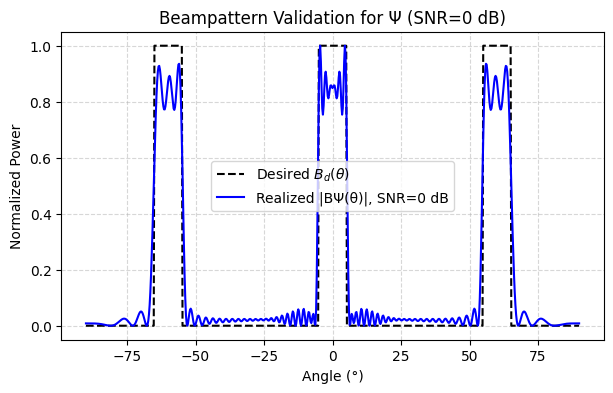


=== Ψ Validation at SNR = 0 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 2.396e-12)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 1 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 2.317e-11)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 2 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 7.199e-12)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 3 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 1.696e-11)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 4 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 7.495e-11)
Beampattern MSE vs desired: 

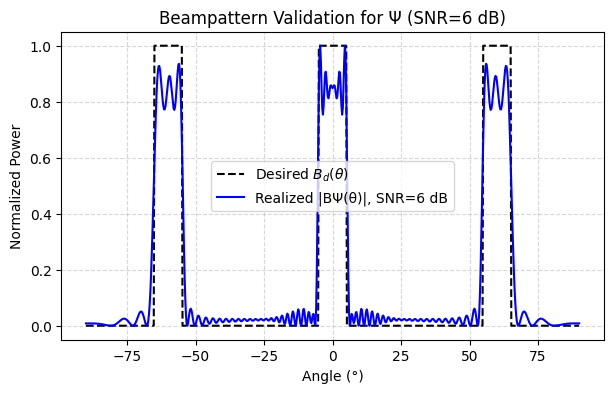


=== Ψ Validation at SNR = 6 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 1.204e-11)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 7 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 1.560e-10)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 8 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 1.964e-11)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 9 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 2.521e-10)
Beampattern MSE vs desired: 1.070e-02

=== Ψ Validation at SNR = 10 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 4.245e-11)
Beampattern MSE vs desired:

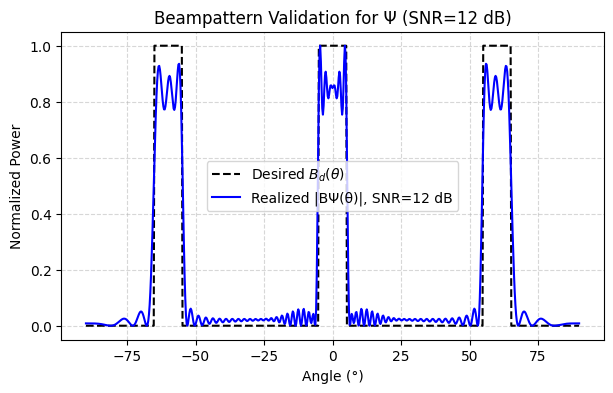


=== Ψ Validation at SNR = 12 dB ===
Diagonal constraint satisfied: True
Hermitian property satisfied: True
PSD property satisfied: True (min eigenvalue: 2.190e-10)
Beampattern MSE vs desired: 1.070e-02

========== SUMMARY ==========
SNR= 0 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 1 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 2 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 3 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 4 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 5 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 6 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 7 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 8 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR= 9 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR=10 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR=11 dB | Diag:True | Herm:True | PSD:True | MSE=1.07e-02
SNR=12 dB | Diag:True | Herm:True | PSD:True |

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# ----------------------------
# CONFIGURATION
# ----------------------------
N = 64                      # Number of antennas
sigma_n2 = 1.0              # Noise variance
SNR_dB_array = np.arange(0, 12.1, 0.1)
theta_targets = np.array([-60, 0, 60])  # desired target angles in degrees
theta_grid = np.linspace(-90, 90, 721)  # fine angular grid for pattern visualization

# Load Psi_all from MATLAB .mat file
with h5py.File("Psi_all.mat", "r") as f:
    Psi_h5 = f["Psi_all"]
    if np.issubdtype(Psi_h5.dtype, np.void):  # MATLAB complex struct
        real = Psi_h5["real"][()]
        imag = Psi_h5["imag"][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)
Psi_all = np.squeeze(Psi_all)  # shape (121, 64, 64)

# ----------------------------
# SUPPORT FUNCTIONS
# ----------------------------

def compute_psi_for_snr(snr_db):
    """Return Psi corresponding to the given SNR dB value."""
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))
    return Psi_all[idx, :, :]

def steering_vector(theta_deg, N):
    """Uniform Linear Array steering vector for angle theta (deg)."""
    theta_rad = np.deg2rad(theta_deg)
    n = np.arange(N)
    return np.exp(1j * np.pi * n * np.sin(theta_rad)) / np.sqrt(N)

def beampattern(Psi, theta_grid):
    """Compute realized beampattern from Psi across an angular grid."""
    B = np.zeros(len(theta_grid), dtype=complex)
    for i, theta in enumerate(theta_grid):
        a = steering_vector(theta, N)
        B[i] = a.conj().T @ Psi @ a
    return B

def desired_beampattern(theta_grid, theta_targets, width=5):
    """Desired beampattern: 1 around target directions, 0 elsewhere."""
    Bd = np.zeros(len(theta_grid))
    for target in theta_targets:
        Bd[np.abs(theta_grid - target) <= width] = 1
    return Bd

# ----------------------------
# VALIDATION FUNCTIONS
# ----------------------------

def check_feasibility(Psi, snr_db, tol=1e-6):
    """Check Ψ ∈ S (Eq. 39): Power constraint, Hermitian, PSD."""
    P_BS = sigma_n2 * 10**(snr_db / 10)
    expected_diag = P_BS / N

    diag_condition = np.allclose(np.diag(Psi), expected_diag, atol=1e-4)
    hermitian_condition = np.allclose(Psi, Psi.conj().T, atol=1e-6)
    eigvals = np.linalg.eigvalsh(Psi)
    psd_condition = np.all(eigvals >= -tol)

    return diag_condition, hermitian_condition, psd_condition, eigvals

def validate_beampattern(Psi, snr_db, plot=True):
    """Compare realized and desired beampatterns."""
    B_real = beampattern(Psi, theta_grid)
    Bd = desired_beampattern(theta_grid, theta_targets)

    # Normalize for comparison
    B_real_norm = np.abs(B_real) / np.max(np.abs(B_real))

    if plot:
        plt.figure(figsize=(7, 4))
        plt.plot(theta_grid, Bd, 'k--', label='Desired $B_d(θ)$')
        plt.plot(theta_grid, B_real_norm, 'b', label=f'Realized |BΨ(θ)|, SNR={snr_db} dB')
        plt.xlabel("Angle (°)")
        plt.ylabel("Normalized Power")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.title(f"Beampattern Validation for Ψ (SNR={snr_db} dB)")
        plt.show()

    mse = np.mean(np.abs(B_real_norm - Bd) ** 2)
    return mse

# ----------------------------
# MAIN VALIDATION LOOP
# ----------------------------

def validate_all_psi():
    results = []

    for snr_db in range(0, 13):
        Psi = compute_psi_for_snr(snr_db)

        diag_ok, herm_ok, psd_ok, eigvals = check_feasibility(Psi, snr_db)
        mse = validate_beampattern(Psi, snr_db, plot=(snr_db % 6 == 0))  # plot at 0,6,12 dB

        print(f"\n=== Ψ Validation at SNR = {snr_db} dB ===")
        print(f"Diagonal constraint satisfied: {diag_ok}")
        print(f"Hermitian property satisfied: {herm_ok}")
        print(f"PSD property satisfied: {psd_ok} (min eigenvalue: {np.min(eigvals):.3e})")
        print(f"Beampattern MSE vs desired: {mse:.3e}")

        results.append({
            "snr_db": snr_db,
            "diag_ok": diag_ok,
            "hermitian_ok": herm_ok,
            "psd_ok": psd_ok,
            "min_eig": np.min(eigvals),
            "mse": mse
        })

    # Summarize feasibility
    print("\n========== SUMMARY ==========")
    for r in results:
        print(f"SNR={r['snr_db']:2d} dB | Diag:{r['diag_ok']} | Herm:{r['hermitian_ok']} | PSD:{r['psd_ok']} | MSE={r['mse']:.2e}")

    return results

# ----------------------------
# EXECUTE VALIDATION
# ----------------------------
if __name__ == "__main__":
    validate_all_psi()
